In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [72]:
# Load datasets
train = pd.read_csv('Dataset/train.csv')
features = pd.read_csv('Dataset/features.csv')
stores = pd.read_csv('Dataset/stores.csv')

In [73]:
# Print dataset shapes
print(f"Train shape: {train.shape}, Features shape: {features.shape}, Stores shape: {stores.shape}")

Train shape: (421570, 5), Features shape: (8190, 12), Stores shape: (45, 3)


In [74]:
# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

In [75]:
# Merge datasets
data = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
data = data.merge(stores, on='Store', how='left')
print(f"Merged data shape: {data.shape}")

Merged data shape: (421570, 16)


In [76]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [77]:
data.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [79]:
data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [80]:
# Handle missing values in MarkDown columns
data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mode().iloc[0])

In [81]:
# Create time-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week
data['DayOfWeek'] = data['Date'].dt.dayofweek

In [82]:
data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
DayOfWeek       0
dtype: int64

In [83]:
# Create lag and rolling average features
data['Lag_1'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
data['Lag_2'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
data['Rolling_Mean_4'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())

data = data.fillna(0)

<Figure size 1200x800 with 0 Axes>

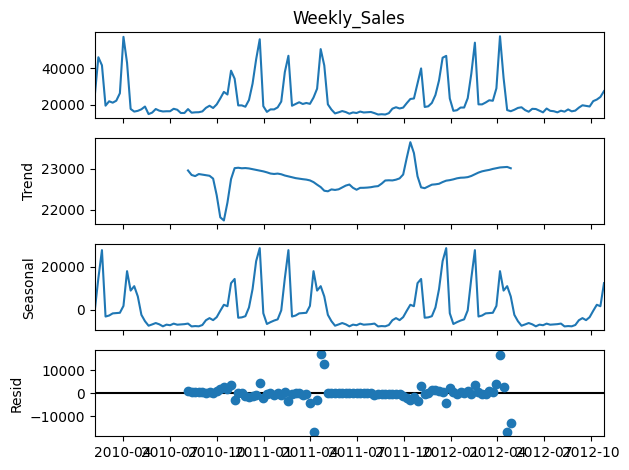

In [84]:
# Seasonal decomposition for a specific store and department
ts_data = data[(data['Store'] == 1) & (data['Dept'] == 1)][['Date', 'Weekly_Sales']].set_index('Date')
decomposition = seasonal_decompose(ts_data['Weekly_Sales'], model='additive', period=52)
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.tight_layout()
plt.savefig('seasonal_decomposition.png')
plt.show()

In [85]:
# Prepare features
features = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 
            'Year', 'Month', 'Week', 'DayOfWeek', 'Lag_1', 'Lag_2', 'Rolling_Mean_4']

# Encode categorical variable 'Type'
data = pd.get_dummies(data, columns=['Type'], drop_first=True)

# Update features list to include dummy variables
features += [col for col in data.columns if col.startswith('Type_')]

In [86]:
# Split data into train and validation sets (time-based split)
train_data = data[data['Date'] < '2012-01-01']
val_data = data[data['Date'] >= '2012-01-01']
X_train = train_data[features]
y_train = train_data['Weekly_Sales']
X_val = val_data[features]
y_val = val_data['Weekly_Sales']

In [87]:
# Train regression models
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_val = lr.predict(X_val)

In [88]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred_train = xgb.predict(X_train)
xgb_pred_val = xgb.predict(X_val)

In [89]:
lgb = LGBMRegressor(random_state=42)
lgb.fit(X_train, y_train)
lgb_pred_train = lgb.predict(X_train)
lgb_pred_val = lgb.predict(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2005
[LightGBM] [Info] Number of data points in the train set: 294132, number of used features: 16
[LightGBM] [Info] Start training from score 16105.306894


In [90]:
# Evaluate models on training and validation sets
print("Training Metrics:")
print("Linear Regression Train RMSE:", np.sqrt(mean_squared_error(y_train, lr_pred_train)))
print("Linear Regression Train R2:", r2_score(y_train, lr_pred_train))
print("XGBoost Train RMSE:", np.sqrt(mean_squared_error(y_train, xgb_pred_train)))
print("XGBoost Train R2:", r2_score(y_train, xgb_pred_train))
print("LightGBM Train RMSE:", np.sqrt(mean_squared_error(y_train, lgb_pred_train)))
print("LightGBM Train R2:", r2_score(y_train, lgb_pred_train))

Training Metrics:
Linear Regression Train RMSE: 7111.426217122585
Linear Regression Train R2: 0.90407718623162
XGBoost Train RMSE: 2478.9090308758005
XGBoost Train R2: 0.9883445331886249
LightGBM Train RMSE: 3181.940683878778
LightGBM Train R2: 0.9807959577953429


In [91]:
print("\nValidation Metrics:")
print("Linear Regression Val RMSE:", np.sqrt(mean_squared_error(y_val, lr_pred_val)))
print("Linear Regression Val R2:", r2_score(y_val, lr_pred_val))
print("XGBoost Val RMSE:", np.sqrt(mean_squared_error(y_val, xgb_pred_val)))
print("XGBoost Val R2:", r2_score(y_val, xgb_pred_val))
print("LightGBM Val RMSE:", np.sqrt(mean_squared_error(y_val, lgb_pred_val)))
print("LightGBM Val R2:", r2_score(y_val, lgb_pred_val))


Validation Metrics:
Linear Regression Val RMSE: 3677.061115468019
Linear Regression Val R2: 0.9723679230855264
XGBoost Val RMSE: 2512.0467768412163
XGBoost Val R2: 0.9871036361684209
LightGBM Val RMSE: 2744.2519802463744
LightGBM Val R2: 0.9846092492412409


In [92]:
# Time-aware cross-validation on training data
tscv = TimeSeriesSplit(n_splits=5)
lr_rmse_scores = []
xgb_rmse_scores = []
lgb_rmse_scores = []
lr_r2_scores = []
xgb_r2_scores = []
lgb_r2_scores = []
for train_idx, test_idx in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Linear Regression
    lr.fit(X_train_cv, y_train_cv)
    lr_pred_cv = lr.predict(X_test_cv)
    lr_rmse_scores.append(np.sqrt(mean_squared_error(y_test_cv, lr_pred_cv)))
    lr_r2_scores.append(r2_score(y_test_cv, lr_pred_cv))
    
    # XGBoost
    xgb.fit(X_train_cv, y_train_cv)
    xgb_pred_cv = xgb.predict(X_test_cv)
    xgb_rmse_scores.append(np.sqrt(mean_squared_error(y_test_cv, xgb_pred_cv)))
    xgb_r2_scores.append(r2_score(y_test_cv, xgb_pred_cv))
    
    # LightGBM
    lgb.fit(X_train_cv, y_train_cv)
    lgb_pred_cv = lgb.predict(X_test_cv)
    lgb_rmse_scores.append(np.sqrt(mean_squared_error(y_test_cv, lgb_pred_cv)))
    lgb_r2_scores.append(r2_score(y_test_cv, lgb_pred_cv))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 49022, number of used features: 15
[LightGBM] [Info] Start training from score 17480.602897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 98044, number of used features: 15
[LightGBM] [Info] Start training from score 18848.640201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

In [93]:
print("\nCross-Validation Metrics:")
print("Linear Regression CV RMSE:", np.mean(lr_rmse_scores))
print("Linear Regression CV R2:", np.mean(lr_r2_scores))
print("XGBoost CV RMSE:", np.mean(xgb_rmse_scores))
print("XGBoost CV R2:", np.mean(xgb_r2_scores))
print("LightGBM CV RMSE:", np.mean(lgb_rmse_scores))
print("LightGBM CV R2:", np.mean(lgb_r2_scores))


Cross-Validation Metrics:
Linear Regression CV RMSE: 7053.450630568759
Linear Regression CV R2: 0.8970234284763066
XGBoost CV RMSE: 3799.5228214605645
XGBoost CV R2: 0.9701847844609184
LightGBM CV RMSE: 3846.996286092908
LightGBM CV R2: 0.9696562015846648


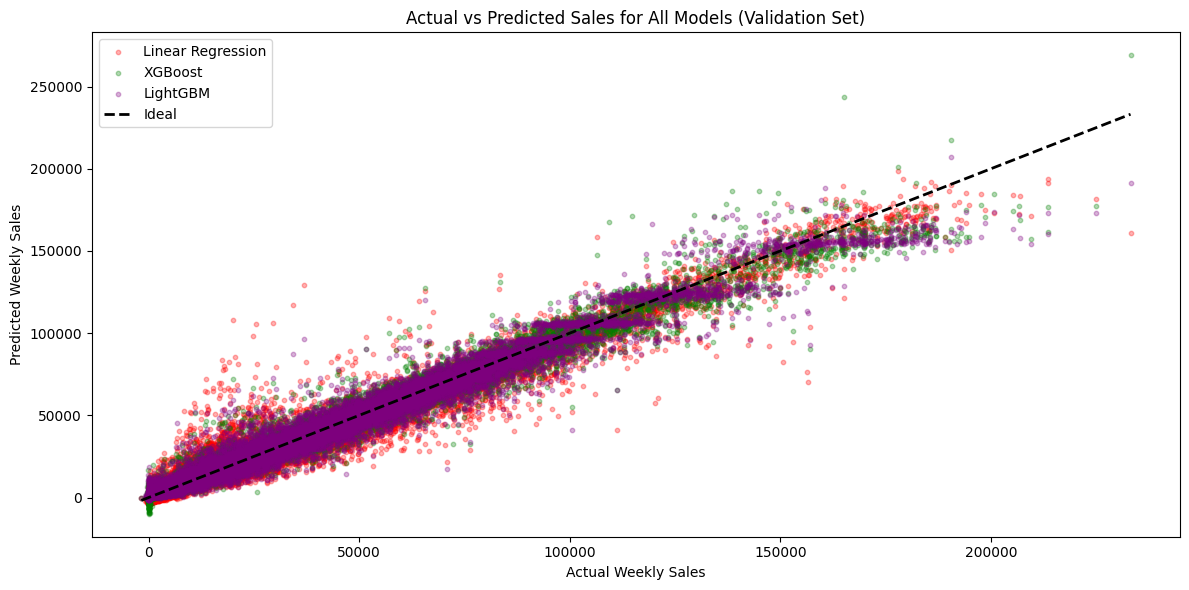

In [94]:
# Scatter plot of actual vs predicted sales (using validation data)
plt.figure(figsize=(12, 6))
plt.scatter(y_val, lr_pred_val, label='Linear Regression', color='red', alpha=0.3, s=10)
plt.scatter(y_val, xgb_pred_val, label='XGBoost', color='green', alpha=0.3, s=10)
plt.scatter(y_val, lgb_pred_val, label='LightGBM', color='purple', alpha=0.3, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('Actual vs Predicted Sales for All Models (Validation Set)')
plt.legend()
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

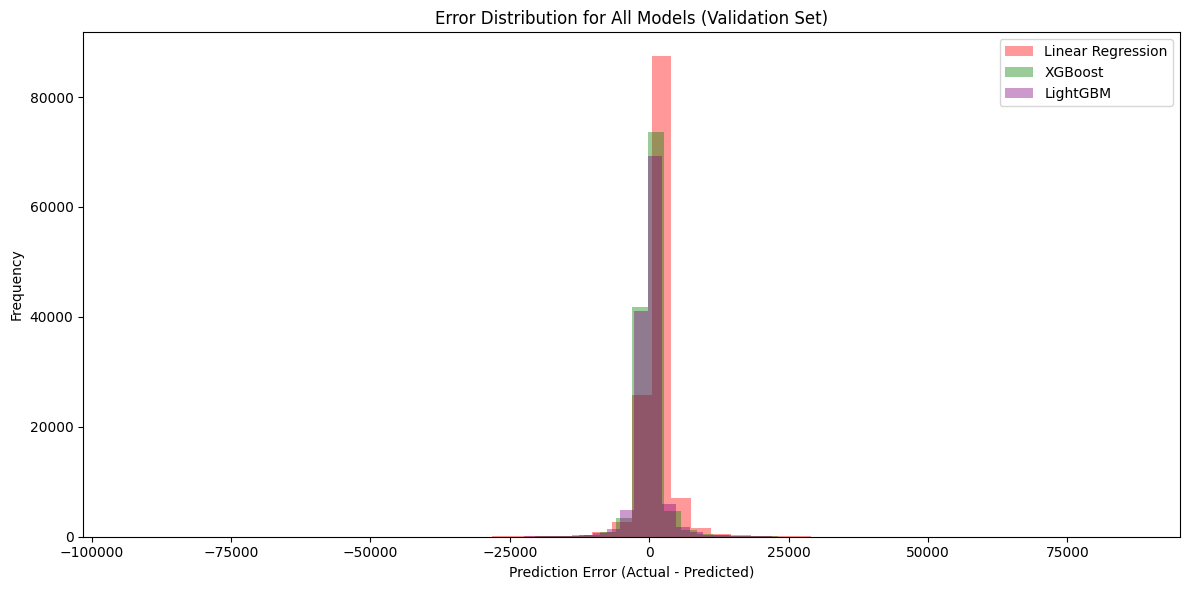

In [95]:
# Error distribution plot for validation set
lr_errors = y_val - lr_pred_val
xgb_errors = y_val - xgb_pred_val
lgb_errors = y_val - lgb_pred_val

plt.figure(figsize=(12, 6))
plt.hist(lr_errors, bins=50, alpha=0.4, label='Linear Regression', color='red')
plt.hist(xgb_errors, bins=50, alpha=0.4, label='XGBoost', color='green')
plt.hist(lgb_errors, bins=50, alpha=0.4, label='LightGBM', color='purple')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Error Distribution for All Models (Validation Set)')
plt.legend()
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.show()

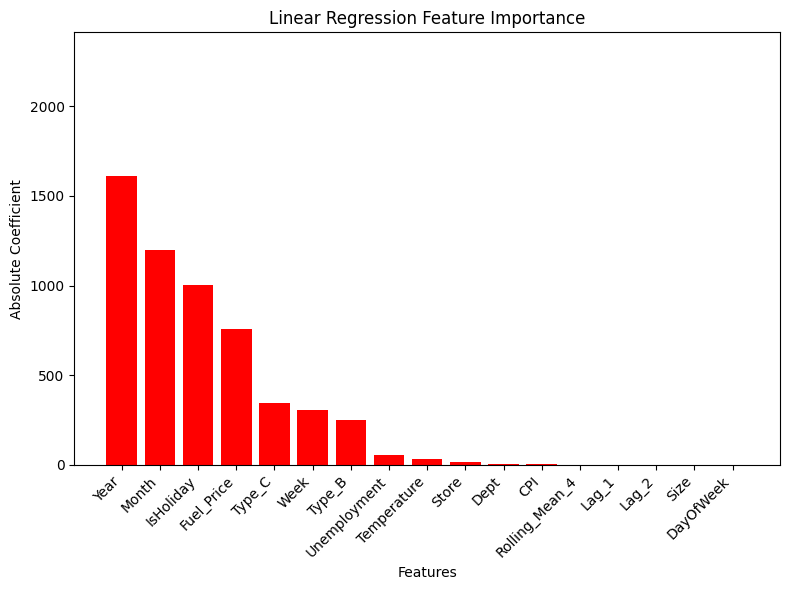

In [96]:
# Linear Regression feature importance
lr_importance = np.abs(lr.coef_)
lr_sorted_idx = np.argsort(lr_importance)[::-1]
plt.figure(figsize=(8, 6))
plt.bar(np.array(features)[lr_sorted_idx], lr_importance[lr_sorted_idx], color='red')
plt.title('Linear Regression Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient')
plt.xticks(rotation=45, ha='right')
max_lr_importance = max(lr_importance) if lr_importance.size > 0 else 0.1
plt.ylim(0, max_lr_importance * 1.5)
plt.tight_layout()
plt.savefig('lr_feature_importance.png')
plt.show()

XGBoost Feature Importances: [0.00309114 0.01040916 0.05299515 0.00217095 0.00234929 0.00160308
 0.00598655 0.00901848 0.00357506 0.01224821 0.01656912 0.
 0.41018224 0.00947126 0.45507702 0.00525323 0.        ]


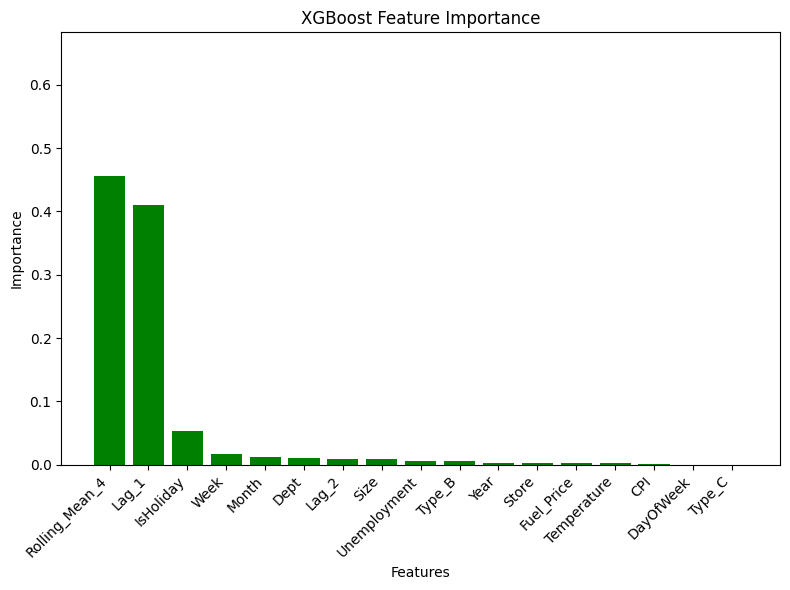

In [97]:
# XGBoost feature importance
xgb_importance = xgb.feature_importances_
print("XGBoost Feature Importances:", xgb_importance)  # Diagnostic print
if len(xgb_importance) == 0 or np.all(xgb_importance == 0):
    print("Warning: XGBoost feature importances are empty or all zero. Check model training.")
    xgb_importance = np.zeros(len(features))  # Fallback to zeros for plotting
xgb_sorted_idx = np.argsort(xgb_importance)[::-1]
plt.figure(figsize=(8, 6))
plt.bar(np.array(features)[xgb_sorted_idx], xgb_importance[xgb_sorted_idx], color='green')
plt.title('XGBoost Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
max_xgb_importance = max(xgb_importance) if xgb_importance.size > 0 else 0.1
plt.ylim(0, max_xgb_importance * 1.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png')
plt.show()

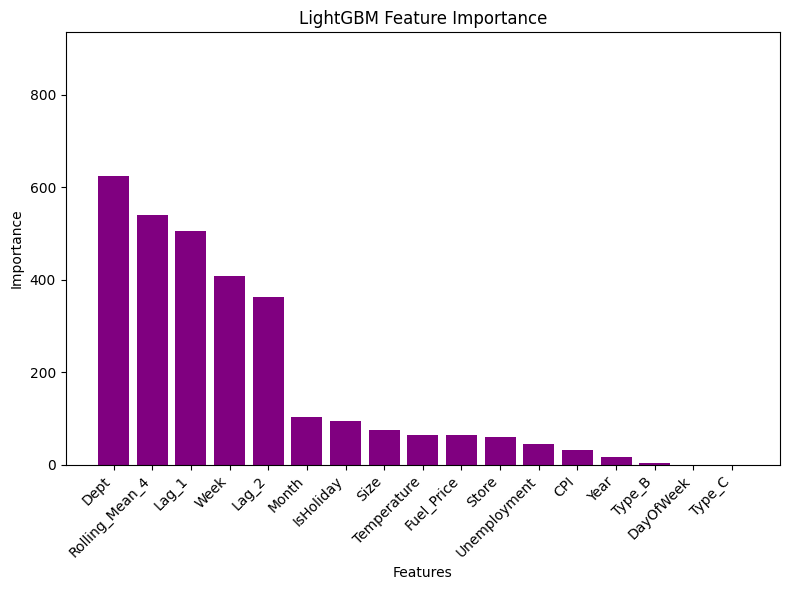

In [98]:
# LightGBM feature importance
lgb_importance = lgb.feature_importances_
lgb_sorted_idx = np.argsort(lgb_importance)[::-1]
plt.figure(figsize=(8, 6))
plt.bar(np.array(features)[lgb_sorted_idx], lgb_importance[lgb_sorted_idx], color='purple')
plt.title('LightGBM Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
max_lgb_importance = max(lgb_importance) if lgb_importance.size > 0 else 0.1
plt.ylim(0, max_lgb_importance * 1.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('lgb_feature_importance.png')
plt.show()